# Iterative Subgraph Screening

In [1]:
import numpy as np
import random

np.random.seed(10)

import graspy
from graspy.simulations import sbm
from graspy.plot import heatmap
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/numba-0.46.0-py3.6-linux-x86_64.egg/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


Subgraph Screening uses rows of adjacency matrices as feature vectors for each node, and finds the correlation of those feature vectors with a covariate of interest. Mathematically speaking, for m graphs, there are m covariates. The correlation values found from screening are 

\begin{align*}
c_{u} = MGC\left(\left\{(\hat{X_{i}}[u,\cdot], Y_{i})\right\}^{m}_{i = 1}\right)
\end{align*}

for covariates of interest $\left\{ Y_{i} \in \mathbb{R}, i = 1, ..., m\right\}$ and feature vectors $\hat{X_{i}}[u,.] = A_{i}[u,\cdot]$, where $A_{i}[u,\cdot]$ is the corresponding row in the adjacency matrix.

The estimated signal subgraph is $\hat{S} = \left\{u \in V|c_{u} > c\right\}$, where $V = [n]$ for adjacency matrices in $\mathbb{R}^{n \ \times \ n}$. 

For iterative screening, correlation values are repeatedly screened according to a user supplied quantile $\delta \in \left(0,1 \right)$. For each iteration, the nodes in $\delta$ quantile are preserved in a new set of lower dimensional graphs $\hat{X_{i}}^{*}$. The correlation values for this are then calculated as 

\begin{align*}
c_{u} = MGC\left(\left\{(\hat{X_{i}}^{*}[u,\cdot], Y_{i})\right\}^{m}_{i = 1}\right)
\end{align*}

The nodes in the $\delta$ quantile are preserved and the cycle is repeated. 

## Generate Mock Data

In [2]:
# Create function to generate mock data

def data_generator(num_graphs, N, n, prob_tensor, percent_vec):

    # Getting the number of classes
    num_types = len(percent_vec)

    # Getting vector with the number of graphs in each class
    num = [int(num_graphs * a) for a in percent_vec]

    # Creating blank arrays for all of the returns
    data = np.zeros((num_graphs, N, N))
    y_label = np.zeros((num_graphs, 1))

    # Creates vector of random indices to randomly distribute graphs in tensor
    L_ind = random.sample(range(0, num_graphs), num_graphs)

    # Loop for creating the returns
    for i in range(num_types):

        # Create tensor that will contain all of the graphs of one type
        types = np.zeros((num[i], N, N))

        # Put all the graphs of one type into types
        for j in range(len(types)):
            types[j] = sbm(n=n, p=prob_tensor[i])

        # Assigns all of the graphs in types to random indices in data
        data[L_ind[: num[i]]] = types

        # Creates corresponding labels
        y_label[L_ind[: num[i]]] = int(i)

        # Gets rid of used indices
        L_ind = L_ind[num[i] :]

    return data, y_label

In [3]:
prob_tensor = np.zeros((2, 2, 2))
prob_tensor[0] = [[0.3, 0.2], [0.2, 0.3]]
prob_tensor[1] = [[0.4, 0.2], [0.2, 0.3]]
n = [20, 180]
percent_vec = np.asarray([0.50, 0.50])
data_samp, y_label_samp = data_generator(100, 200, n, prob_tensor, percent_vec)

#Create signal subgraph label vector, 
#indicating which nodes are in the signal subgraph.

ss_label = np.zeros(200)
ss_label[:20] = 1

## Usage

In [4]:
from graspy.subgraph import ItScreen

# Screening with Multiscale Graph Correlation (MGC)
screen = ItScreen("mgc", 0.50, 20)

#Correlations
screen.fit(data_samp, y_label_samp)

#Estimated Signal Subgraph
S_hat = screen.fit_transform(data_samp, y_label_samp)

In [5]:
# Print Correlation Values and Estimated Signal Subgraph
print(screen.corrs)

print(S_hat)

[[3.06600554]
 [3.01547284]
 [3.039849  ]
 [2.02184239]
 [3.02741806]
 [3.05422116]
 [3.05862726]
 [3.05356242]
 [1.00064726]
 [3.04279552]
 [3.04094719]
 [0.99760467]
 [3.08311953]
 [3.02708657]
 [3.05056475]
 [1.00187071]
 [3.04475931]
 [3.12370173]
 [3.04472651]
 [2.00269486]
 [3.04008852]
 [0.98450528]
 [2.01182225]
 [0.99286255]
 [3.02504942]
 [0.98138225]
 [0.99466237]
 [0.99767766]
 [0.99930278]
 [2.00102281]
 [1.00083674]
 [3.0625777 ]
 [0.98903584]
 [1.99851851]
 [1.99795565]
 [0.99921358]
 [1.00216826]
 [3.030297  ]
 [2.00877576]
 [1.00152827]
 [0.98464311]
 [3.02827006]
 [1.00175086]
 [2.02225113]
 [1.00285283]
 [3.03442782]
 [0.99718622]
 [0.98765124]
 [2.01256847]
 [0.9882503 ]
 [0.98666523]
 [2.01908681]
 [0.96978645]
 [0.99875713]
 [0.99813558]
 [0.99983493]
 [0.99923601]
 [1.00240115]
 [0.97173321]
 [1.00010744]
 [3.02973359]
 [0.98966429]
 [2.01827511]
 [2.00787716]
 [2.00989036]
 [0.9941887 ]
 [2.00437767]
 [0.99065573]
 [3.02839294]
 [1.9955813 ]
 [0.98367418]
 [3.01

Estimation for the Signal Subgraph Nodes:
[  0   2   5   6   7   9  10  12  14  16  17  18  20  31  76 107 118 157
 192 196]


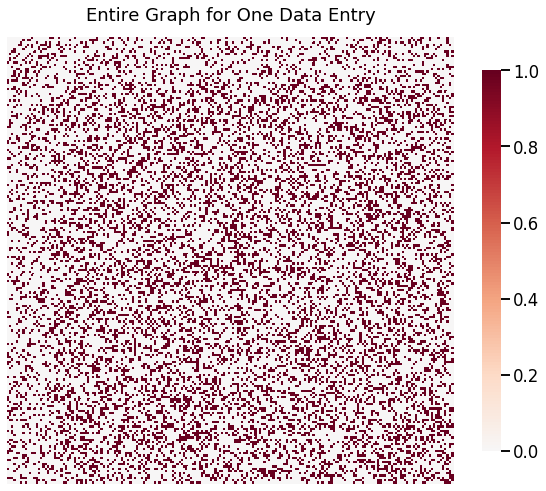

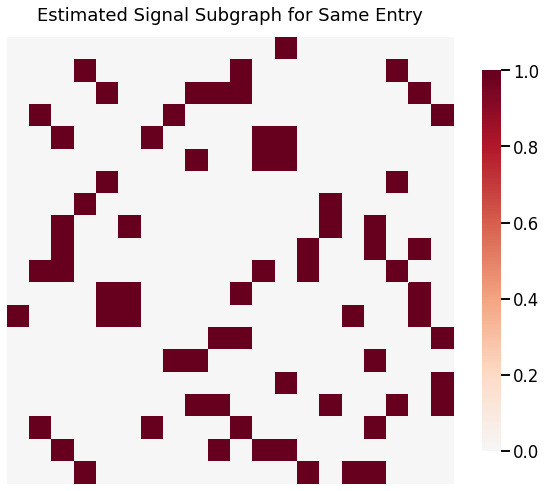

In [6]:
# Visualizing the Data

heatmap(data_samp[0], title='Entire Graph for One Data Entry')

heatmap(S_hat[0], title='Estimated Signal Subgraph for Same Entry')

print("Estimation for the Signal Subgraph Nodes:")
print(screen.subgraph_inds)

## Accuracy

The AUC value is the area under the ROC curve.
This is a measurement of the accuracy of the estimation.
The closer to 1, the better.
AUC Value: 0.8516666666666667


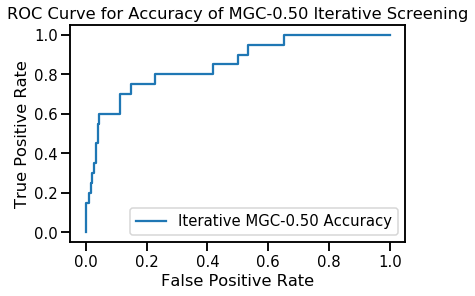

In [7]:
import seaborn as sns
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

fpr, tpr, threshold = metrics.roc_curve(ss_label, screen.corrs)

sns.set_context("talk", font_scale=0.90)
plt.title("ROC Curve for Accuracy of MGC-0.50 Iterative Screening")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.step(fpr, tpr, label="Iterative MGC-0.50 Accuracy")
plt.legend()

auc_val = metrics.auc(fpr, tpr)
print("The AUC value is the area under the ROC curve.")
print("This is a measurement of the accuracy of the estimation.")
print("The closer to 1, the better.")
print("AUC Value:", auc_val)

## Generate Mock Data

In [12]:
# 3 Types
prob_tensor = np.zeros((3, 2, 2))
prob_tensor[0] = [[0.3, 0.2], [0.2, 0.3]]
prob_tensor[1] = [[0.4, 0.2], [0.2, 0.3]]
prob_tensor[2] = [[0.5, 0.2], [0.2, 0.3]]
n = [20, 180]
percent_vec = np.asarray([0.30, 0.30, 0.40])
data_samp, y_label_samp = data_generator(100, 200, n, prob_tensor, percent_vec)

#Create signal subgraph label vector, 
#indicating which nodes are in the signal subgraph.

ss_label = np.zeros(200)
ss_label[:20] = 1

In [13]:
# Now with Distance Correlation (DCORR)
screen = ItScreen("dcorr", 0.50, 20)

#Correlations
screen.fit(data_samp, y_label_samp)

#Estimated Signal Subgraph
S_hat = screen.fit_transform(data_samp, y_label_samp)

Estimation for the Signal Subgraph Nodes:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  18
  19 156]


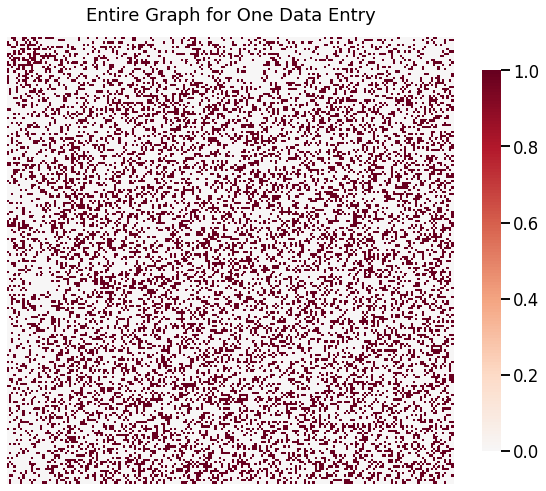

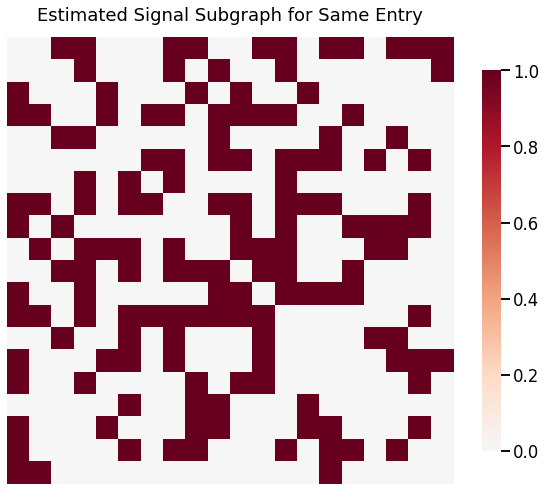

In [14]:
# Visualizing the Data

heatmap(data_samp[0], title='Entire Graph for One Data Entry')

heatmap(S_hat[0], title='Estimated Signal Subgraph for Same Entry')

print("Estimation for the Signal Subgraph Nodes:")
print(screen.subgraph_inds)

## Accuracy

AUC Value: 0.97


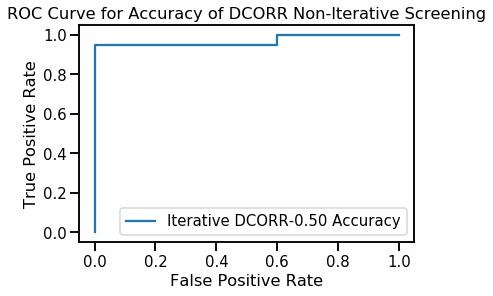

In [15]:
import seaborn as sns
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

fpr, tpr, threshold = metrics.roc_curve(ss_label, screen.corrs)

sns.set_context("talk", font_scale=0.90)
plt.title("ROC Curve for Accuracy of DCORR Non-Iterative Screening")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.step(fpr, tpr, label="Iterative DCORR-0.50 Accuracy")
plt.legend()

auc_val = metrics.auc(fpr, tpr)
print("AUC Value:", auc_val)